In [2]:
%matplotlib inline

import json
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [3]:
dataset_df = pd.read_csv('spam_ham_dataset.csv', index_col=0)
dataset_df.head()

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


## Preprocess
### Tokenizing

In [4]:
# #cant use this because this data has space in between possession, ie. (It ' s, we ' re)
#https://stackoverflow.com/questions/58105967/spacy-tokenization-of-hyphenated-words

In [5]:
from nltk.tokenize import word_tokenize 
with open('special-chars.txt') as f:
    special_char = ['\\' + x.strip() for x in f.readlines()]
special_char =  special_char+ ["[0-9]", "-"] # -  is for this corrupt data only
def remove_special_char(element):
    if re.search('|'.join(special_char), element):
        return False
    else:
        return True
def tokenize(raw):
    tokens = word_tokenize(raw) 
    tokens = list(filter(remove_special_char, tokens))
    
    return tokens

tokens = dataset_df.text.apply(tokenize)
tokens.head()

605     [Subject, enron, methanol, meter, this, is, a,...
2349    [Subject, hpl, nom, for, january, see, attache...
3624    [Subject, neon, retreat, ho, ho, ho, we, re, a...
4685    [Subject, photoshop, windows, office, cheap, m...
2030    [Subject, re, indian, springs, this, deal, is,...
Name: text, dtype: object

### Remove stop words

In [6]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
def remove_stop_words(word_tokens):
    return [w for w in word_tokens if not w in stop_words] 

tokens_no_stop_words = tokens.apply(remove_stop_words)
tokens_no_stop_words.head()

605     [Subject, enron, methanol, meter, follow, note...
2349    [Subject, hpl, nom, january, see, attached, fi...
3624    [Subject, neon, retreat, ho, ho, ho, around, w...
4685    [Subject, photoshop, windows, office, cheap, m...
2030    [Subject, indian, springs, deal, book, teco, p...
Name: text, dtype: object

### Word embedding (to feature vector)

In [7]:
#join the tokens to put in CountVectorizer
sentences_no_stop_words = [' '.join(x) for x in tokens_no_stop_words]
X, y = np.array(sentences_no_stop_words), dataset_df.label_num.to_numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X_train_embedded = vectorizer.fit_transform(X_train)
X_test_embedded = vectorizer.transform(X_test)

## Model training
### Baseline

In [8]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_embedded, y_train)
print(f'Accuracy {clf.score(X_test_embedded, y_test)}')

Accuracy 0.9739130434782609


In [9]:
my_mail = """
Hi ktgiahieuchatbot — thanks for signing up!

If you need any help, or have any comments, you can use the Feedback link from most pages on PythonAnywhere, you can drop us an email at support@pythonanywhere.com, or you can post on our forums. We'd love to hear from you!

We try to keep email to a minimum, so for the latest PythonAnywhere news, check out:

Our Twitter account, @pythonanywhere
Our blog
We'll send you a separate email to confirm your email address -- make sure you do that, otherwise we won't be able to do things like reset your password if you forget it.

We hope everything goes well, and once again, if you need help, please don't hesitate to get in touch.

Happy Pythoning!

Filip

We need to provide you with the following information to comply with legislation:

We will provide you with a PythonAnywhere account, which allows you to run your code on our servers, including creating one or more public websites.
This will cost you nothing unless you switch to a different kind of account on our "Accounts" page or you have already signed up for a paid account. If you have signed up for a paid account, we will send you another email confirming the monthly price and the features you have paid for.
This is to remind you that, if you are an EEA consumer, you may have the right to cancel the contract (that is, to delete your account) within 14 days of concluding the contract. (This right does not apply in certain circumstances, e.g. contracts which are completed.) You must send us clear statement saying that you wish to cancel via email to support@pythonanywhere.com. We will refund all payments within 14 days thereafter but, if you agreed to us beginning services during the cancellation period, we will deduct reasonable costs to cover the services we performed. For full details, please see our terms and conditions. This is separate from our (actually more generous) 30-day no-questions-asked money-back guarantee.
You can end the contract at any time as explained on our service. This does not give rise to a refund unless “cooling off” rights apply.
You may be entitled to use an EU online dispute resolution service to assist with any contractual dispute you may have with us. This service can be found here."""
my_token = tokenize(my_mail)
my_token_no_stop_words = remove_stop_words(my_token)
my_sentence_no_stop_words = ' '.join(my_token_no_stop_words)
my_data = vectorizer.transform([my_sentence_no_stop_words])
clf.predict_proba(my_data)

array([[9.99984907e-01, 1.50929646e-05]])

### Validate model

In [10]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'], capsize=5, elinewidth=1)
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(Fresh)")
    remove_border(ax)
    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(x=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(Fresh)")
    remove_border()
    plt.ylabel("Number")

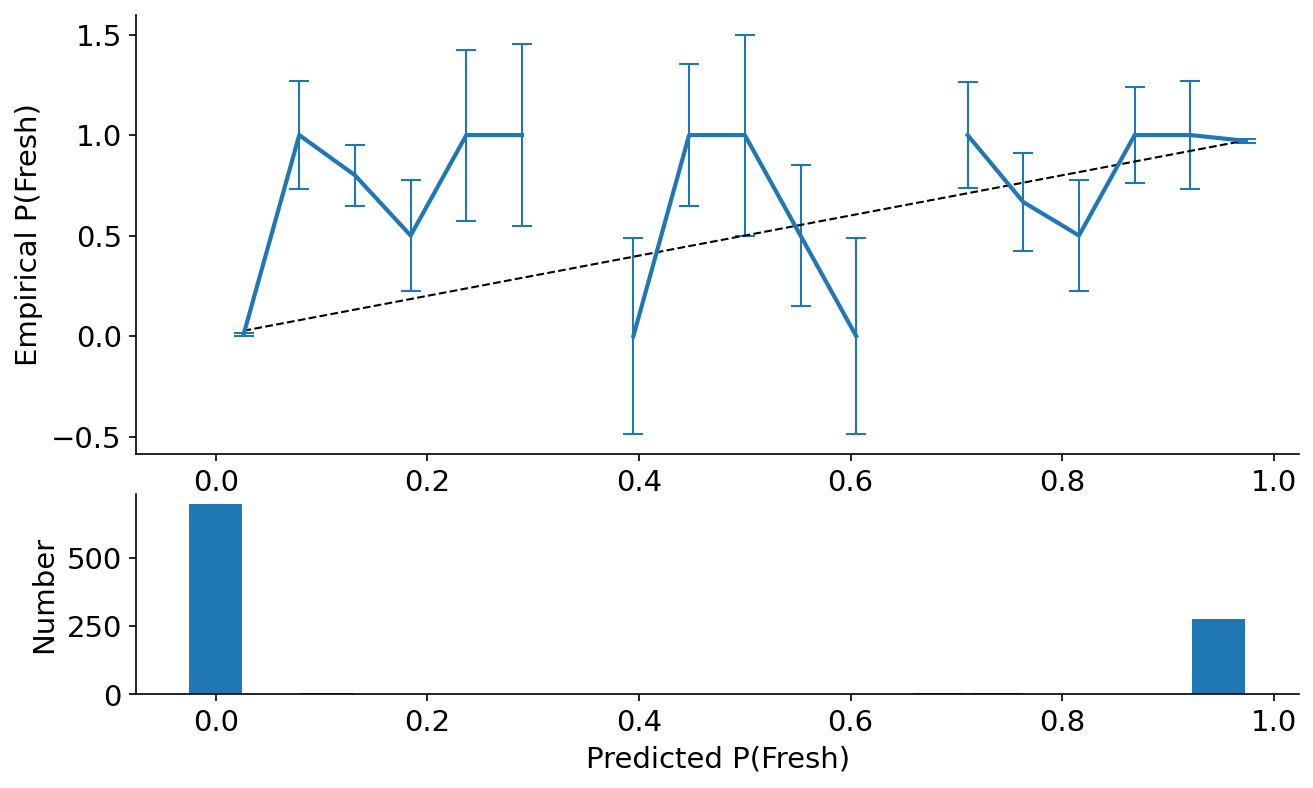

In [11]:
calibration_plot(clf, X_test_embedded, y_test)

### Cross validation (hyperparams tuning)

In [12]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [13]:
from sklearn.model_selection import KFold

def cv_score(clf, vectorizer, X, y, score_func):
    result = 0
    nfold = 5
    kf = KFold(n_splits=nfold)
    for train, valid in kf.split(X): # split data into train/test groups, 5 times
        X_train_embedded = vectorizer.fit_transform(X[train])
        X_valid_embedded = vectorizer.transform(X[valid])
        clf.fit(X_train_embedded, y[train]) # fit
        result += score_func(clf, X_valid_embedded, y[valid]) # evaluate score function on held-out data
    return result / nfold # average


In [14]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, y = X_train, y_train
        clf = MultinomialNB(alpha=alpha)
        loglike = cv_score(clf, vectorizer, X, y, log_likelihood)

        if loglike > max_loglike:
            max_loglike = loglike
            best_alpha, best_min_df = alpha, min_df

In [15]:
print("alpha: %f" % best_alpha)
print("min_df: %f" % best_min_df)

alpha: 5.000000
min_df: 0.000010


#### Retrain the model

In [16]:
vectorizer = CountVectorizer(min_df = 0.000010)
X_train_embedded = vectorizer.fit_transform(X_train)
X_test_embedded = vectorizer.transform(X_test)

clf = MultinomialNB(alpha = 5.0).fit(X_train_embedded, y_train)
print(f'Accuracy {clf.score(X_test_embedded, y_test)}')

Accuracy 0.9642512077294686


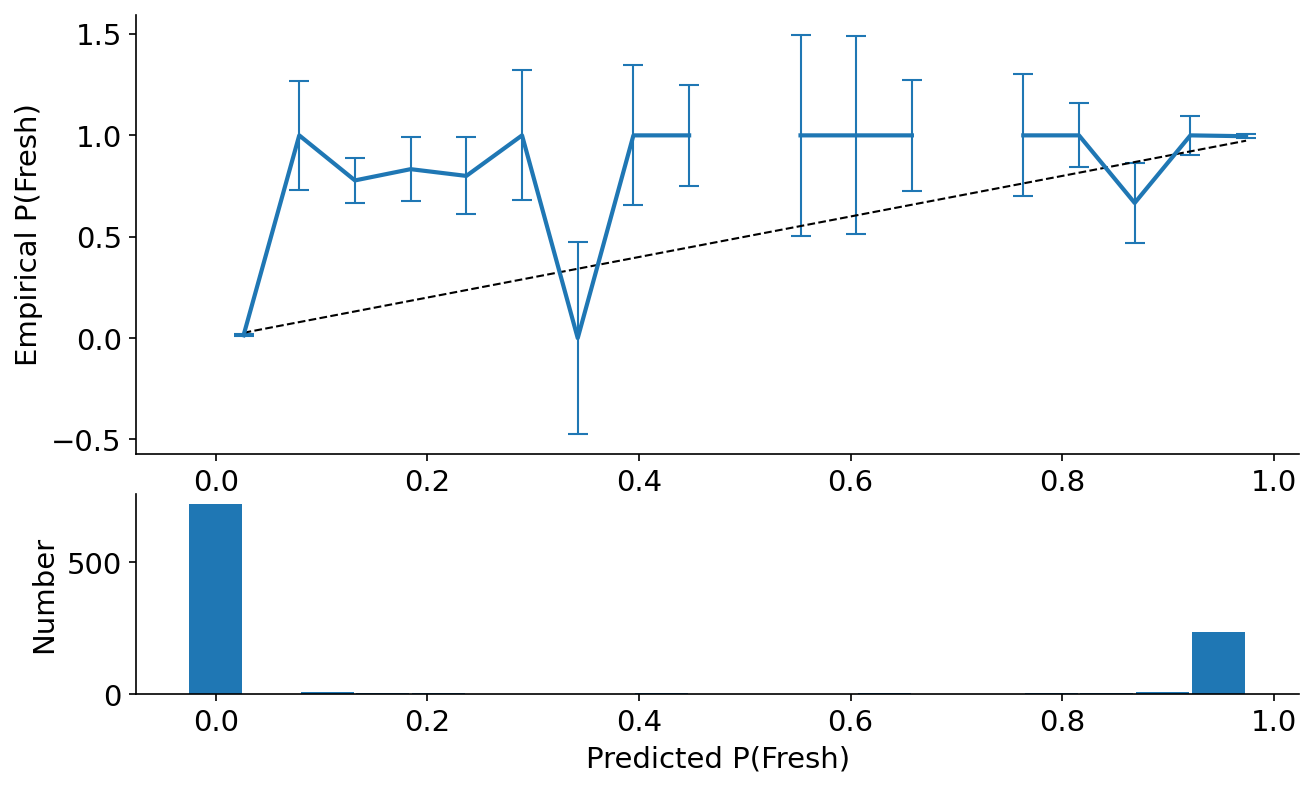

In [17]:
calibration_plot(clf, X_test_embedded, y_test)

## Save model

In [18]:
import pickle
# save the model to disk
filename = 'spam_classifier.sav'
pickle.dump(clf, open(filename, 'wb'))

filename = 'spam_vectorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

In [19]:
# some time later...
 
# load the model from disk
loaded_vectorizer = pickle.load(open('spam_vectorizer.sav', 'rb'))
loaded_clf = pickle.load(open('spam_classifier.sav', 'rb'))
my_mail = """
Hi ktgiahieuchatbot — thanks for signing up!

If you need any help, or have any comments, you can use the Feedback link from most pages on PythonAnywhere, you can drop us an email at support@pythonanywhere.com, or you can post on our forums. We'd love to hear from you!

We try to keep email to a minimum, so for the latest PythonAnywhere news, check out:

Our Twitter account, @pythonanywhere
Our blog
We'll send you a separate email to confirm your email address -- make sure you do that, otherwise we won't be able to do things like reset your password if you forget it.

We hope everything goes well, and once again, if you need help, please don't hesitate to get in touch.

Happy Pythoning!

Filip

We need to provide you with the following information to comply with legislation:

We will provide you with a PythonAnywhere account, which allows you to run your code on our servers, including creating one or more public websites.
This will cost you nothing unless you switch to a different kind of account on our "Accounts" page or you have already signed up for a paid account. If you have signed up for a paid account, we will send you another email confirming the monthly price and the features you have paid for.
This is to remind you that, if you are an EEA consumer, you may have the right to cancel the contract (that is, to delete your account) within 14 days of concluding the contract. (This right does not apply in certain circumstances, e.g. contracts which are completed.) You must send us clear statement saying that you wish to cancel via email to support@pythonanywhere.com. We will refund all payments within 14 days thereafter but, if you agreed to us beginning services during the cancellation period, we will deduct reasonable costs to cover the services we performed. For full details, please see our terms and conditions. This is separate from our (actually more generous) 30-day no-questions-asked money-back guarantee.
You can end the contract at any time as explained on our service. This does not give rise to a refund unless “cooling off” rights apply.
You may be entitled to use an EU online dispute resolution service to assist with any contractual dispute you may have with us. This service can be found here."""
my_token = tokenize(my_mail)
my_token_no_stop_words = remove_stop_words(my_token)
my_sentence_no_stop_words = ' '.join(my_token_no_stop_words)
my_data = loaded_vectorizer.transform([my_sentence_no_stop_words])
result = loaded_clf.predict_proba(my_data)
print(result)

[[1.00000000e+00 1.72783648e-14]]
